In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import copy
from glob import glob
from PIL import Image, ImageFile
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import recgn_utils # utility script 

In [2]:
# Verifica se CUDA está disponível 
gpu_on = torch.cuda.is_available()

if not gpu_on:
    print('Use a CPU. CUDA não está disponível...')
else:
    print('Use a GPU. CUDA está disponível...')

Use a GPU. CUDA está disponível...


In [3]:
# Configure alguns parametros:

# Path raiz do dataset 
dogs_dir = '../input/dog-breed-recognition-v3/dogs/'

# Tamanho do dataset
batch_size = 32

# Numero de workers
num_workers = 0

# Numero de epocas
num_epochs = 20

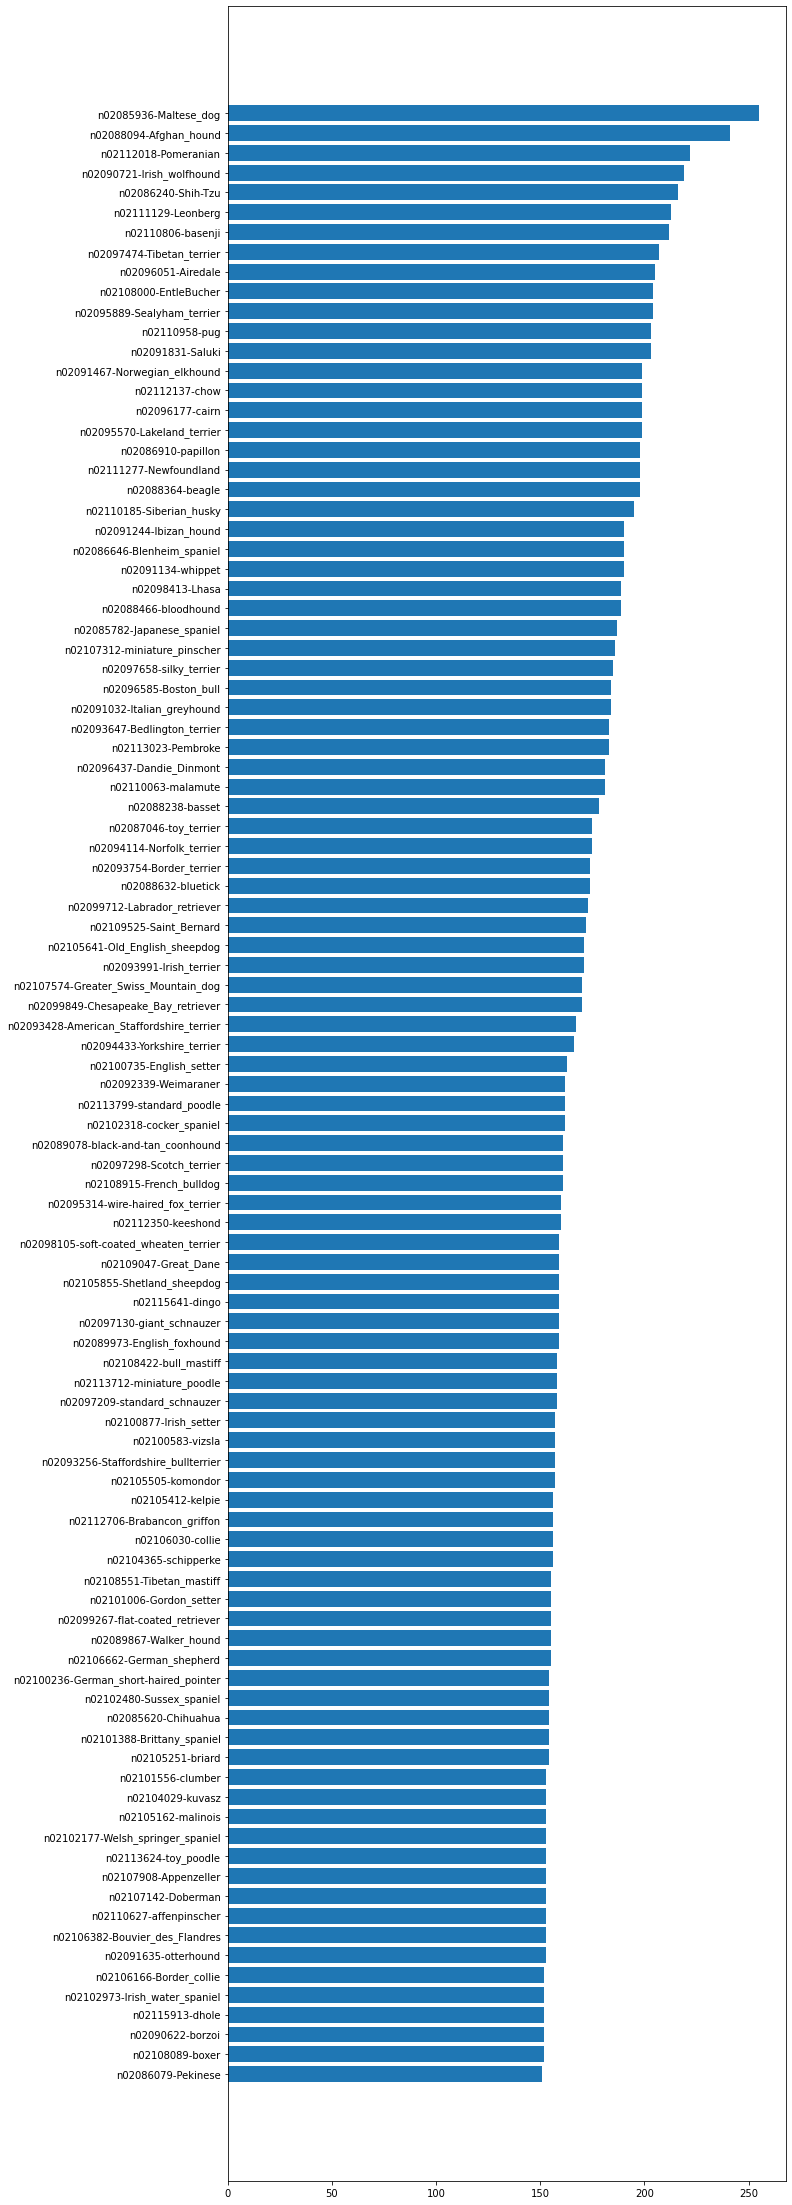

In [4]:
# Carrega o dataset usando ImageFolder
data_dir = dogs_dir + 'train'
class_names = [item.split('/')[-2] for item in sorted(glob(data_dir + "/*/"))]

# Plota quantidade ordenada de imagens por classe, para verficar se estao desbalanceadas
_, _ = recgn_utils.check_class(data_dir)

# Calcula numero de classes
num_classes = len(class_names)

# Cria dataset de imagens     
ds_train = datasets.ImageFolder(data_dir)

# Calcula total de imagens
total_img = len(ds_train)

In [5]:
# Define tamanho dos datasets, multiplos do batch qunado possivel
train_size = math.ceil(total_img*0.8/batch_size) * batch_size
valid_size = math.ceil(total_img*0.1/batch_size) * batch_size
test_size = total_img - (train_size + valid_size)

# Divide dataset em datasets disjuntos de treinamento, validação e teste
train_set, val_set, test_set = random_split(ds_train, [train_size, valid_size, test_size],
                                            torch.Generator().manual_seed(2147483647))

print(f'Numero de classes: {num_classes}')
print(f'Numero de imagens de treinamento: {len(train_set)}')
print(f'Numero de imagens de validacao: {len(val_set)}')
print(f'Numero de imagens de testes: {len(test_set)}')

Numero de classes: 100
Numero de imagens de treinamento: 13888
Numero de imagens de validacao: 1760
Numero de imagens de testes: 1697


In [6]:
# Define valores mean e std para normalizar as imagens
# TODO: Valores baseados no ImageNet. Idealmente calcular o mean e std do dataset original
img_mean = np.array((0.485, 0.456, 0.406))
img_std = np.array((0.229, 0.224, 0.225))

# Define e aplica transformações nos datasets de treinamento, validação e teste
train_set.dataset = copy(ds_train)
train_set.dataset.transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])
val_set.dataset.transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])
test_set.dataset.transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])
# Cria conjunto de loaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

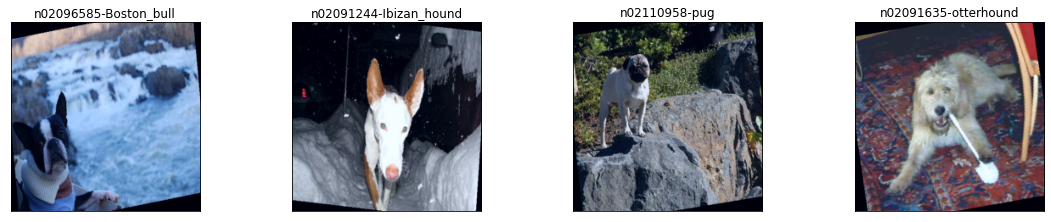

In [7]:
# Exibe algumas imagens do loader com correspondentes labels

meanm = np.mean(img_mean)
stdm = np.mean(img_std)        
recgn_utils.sample_img_show(train_loader, class_names, meanm, stdm)        

In [8]:
# Configuração do Transfer Learning

# Seleciona modelo pre-treinado
# https://pytorch.org/hub/pytorch_vision_resnet/
model = models.resnet152(pretrained=True)
print(f'Camada fully connected da ResNet152: \n{model.fc}')

# Descongela camadas para treinamento (fine-tunning)
for param in model.parameters():
    param.requires_grad = True
    
# Redefine camada fully connected
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(256, num_classes),
                                  nn.LogSoftmax(dim=1)) 
print(f'\nNovo classificador: \n{model.fc}')

# Define loss function (categorical cross-entropy)
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
criterion = nn.NLLLoss()

# Define otimizador de treinamento e diferentes taxas de aprendizado ao longo da rede
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())
optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': 0.001}
        ], lr=0.0001, momentum=0.9)

if gpu_on:
    model.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Camada fully connected da ResNet152: 
Linear(in_features=2048, out_features=1000, bias=True)

Novo classificador: 
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=100, bias=True)
  (6): LogSoftmax(dim=1)
)


Treinando Modelo | Epoca 1: 100%|██████████| 434/434 [06:05<00:00,  1.19it/s]
Validando Modelo | Epoca 1: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


Validation Loss aumentou! (0.000000 --> 4.351475).
Epoca: 1 	Training Loss: 4.5154 	Validation Loss: 4.3515 	Acuracia: 13.6364%


Treinando Modelo | Epoca 2: 100%|██████████| 434/434 [05:18<00:00,  1.36it/s]
Validando Modelo | Epoca 2: 100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoca: 2 	Training Loss: 3.9224 	Validation Loss: 3.0859 	Acuracia: 47.8977%


Treinando Modelo | Epoca 3: 100%|██████████| 434/434 [05:16<00:00,  1.37it/s]
Validando Modelo | Epoca 3: 100%|██████████| 55/55 [00:15<00:00,  3.52it/s]


Epoca: 3 	Training Loss: 2.4670 	Validation Loss: 1.4596 	Acuracia: 75.3409%


Treinando Modelo | Epoca 4: 100%|██████████| 434/434 [05:17<00:00,  1.37it/s]
Validando Modelo | Epoca 4: 100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoca: 4 	Training Loss: 1.5000 	Validation Loss: 0.9318 	Acuracia: 77.7841%


Treinando Modelo | Epoca 5: 100%|██████████| 434/434 [05:18<00:00,  1.36it/s]
Validando Modelo | Epoca 5: 100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Epoca: 5 	Training Loss: 1.1051 	Validation Loss: 0.7274 	Acuracia: 81.1932%


Treinando Modelo | Epoca 6: 100%|██████████| 434/434 [05:19<00:00,  1.36it/s]
Validando Modelo | Epoca 6: 100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Epoca: 6 	Training Loss: 0.9093 	Validation Loss: 0.6498 	Acuracia: 82.1591%


Treinando Modelo | Epoca 7: 100%|██████████| 434/434 [05:19<00:00,  1.36it/s]
Validando Modelo | Epoca 7: 100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoca: 7 	Training Loss: 0.7882 	Validation Loss: 0.6130 	Acuracia: 81.5341%


Treinando Modelo | Epoca 8: 100%|██████████| 434/434 [05:19<00:00,  1.36it/s]
Validando Modelo | Epoca 8: 100%|██████████| 55/55 [00:15<00:00,  3.56it/s]


Epoca: 8 	Training Loss: 0.6988 	Validation Loss: 0.5702 	Acuracia: 82.7273%


Treinando Modelo | Epoca 9: 100%|██████████| 434/434 [05:20<00:00,  1.35it/s]
Validando Modelo | Epoca 9: 100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoca: 9 	Training Loss: 0.6347 	Validation Loss: 0.5628 	Acuracia: 82.4432%


Treinando Modelo | Epoca 10: 100%|██████████| 434/434 [05:21<00:00,  1.35it/s]
Validando Modelo | Epoca 10: 100%|██████████| 55/55 [00:15<00:00,  3.50it/s]


Epoca: 10 	Training Loss: 0.5828 	Validation Loss: 0.5378 	Acuracia: 83.6364%


Treinando Modelo | Epoca 11: 100%|██████████| 434/434 [05:21<00:00,  1.35it/s]
Validando Modelo | Epoca 11: 100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Validation Loss aumentou! (0.537775 --> 0.541397).
Epoca: 11 	Training Loss: 0.5345 	Validation Loss: 0.5414 	Acuracia: 83.4659%


Treinando Modelo | Epoca 12: 100%|██████████| 434/434 [05:22<00:00,  1.35it/s]
Validando Modelo | Epoca 12: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoca: 12 	Training Loss: 0.5018 	Validation Loss: 0.5169 	Acuracia: 83.9773%


Treinando Modelo | Epoca 13: 100%|██████████| 434/434 [05:21<00:00,  1.35it/s]
Validando Modelo | Epoca 13: 100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Validation Loss aumentou! (0.516890 --> 0.528465).
Epoca: 13 	Training Loss: 0.4588 	Validation Loss: 0.5285 	Acuracia: 83.8068%


Treinando Modelo | Epoca 14: 100%|██████████| 434/434 [05:22<00:00,  1.35it/s]
Validando Modelo | Epoca 14: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoca: 14 	Training Loss: 0.4448 	Validation Loss: 0.5249 	Acuracia: 83.8068%


Treinando Modelo | Epoca 15: 100%|██████████| 434/434 [05:22<00:00,  1.34it/s]
Validando Modelo | Epoca 15: 100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoca: 15 	Training Loss: 0.4067 	Validation Loss: 0.5199 	Acuracia: 84.4318%


Treinando Modelo | Epoca 16: 100%|██████████| 434/434 [05:23<00:00,  1.34it/s]
Validando Modelo | Epoca 16: 100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Validation Loss aumentou! (0.519906 --> 0.521778).
Epoca: 16 	Training Loss: 0.3874 	Validation Loss: 0.5218 	Acuracia: 84.2045%


Treinando Modelo | Epoca 17: 100%|██████████| 434/434 [05:25<00:00,  1.33it/s]
Validando Modelo | Epoca 17: 100%|██████████| 55/55 [00:15<00:00,  3.57it/s]


Validation Loss aumentou! (0.521778 --> 0.527395).
Epoca: 17 	Training Loss: 0.3636 	Validation Loss: 0.5274 	Acuracia: 84.1477%


Treinando Modelo | Epoca 18: 100%|██████████| 434/434 [05:25<00:00,  1.33it/s]
Validando Modelo | Epoca 18: 100%|██████████| 55/55 [00:15<00:00,  3.50it/s]


Validation Loss aumentou! (0.527395 --> 0.538150).
Epoca: 18 	Training Loss: 0.3397 	Validation Loss: 0.5381 	Acuracia: 83.0114%


Treinando Modelo | Epoca 19: 100%|██████████| 434/434 [05:26<00:00,  1.33it/s]
Validando Modelo | Epoca 19: 100%|██████████| 55/55 [00:15<00:00,  3.52it/s]


Epoca: 19 	Training Loss: 0.3258 	Validation Loss: 0.5309 	Acuracia: 83.8068%


Treinando Modelo | Epoca 20: 100%|██████████| 434/434 [05:26<00:00,  1.33it/s]
Validando Modelo | Epoca 20: 100%|██████████| 55/55 [00:15<00:00,  3.51it/s]


Validation Loss aumentou! (0.530853 --> 0.538299).
Epoca: 20 	Training Loss: 0.3063 	Validation Loss: 0.5383 	Acuracia: 83.6932%


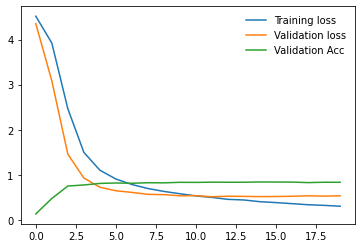

In [9]:
# Treina modelo 

valid_loss_min = 0
model = recgn_utils.train_model(model, criterion, optimizer, loaders, num_epochs, valid_loss_min, gpu_on)

In [10]:
# Testa modelo treinado com loader de testes

prob_pass, prob_fail = recgn_utils.test_model(model, criterion, test_loader, gpu_on)

Testando Modelo:: 100%|██████████| 54/54 [00:24<00:00,  2.24it/s]

Test Loss: 0.729418
Acuracia do Teste: 83% (1418/1697)


Text(0.5, 1.0, 'Max outputs')

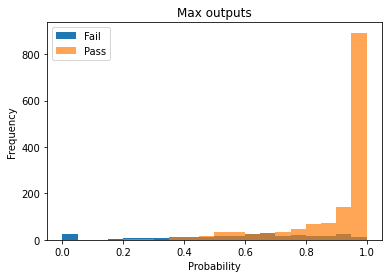

In [11]:
# Plota distribuição de probabilidades nos cassos de pass e fail do teste   

plt.hist(prob_fail, bins = np.arange(0,1.05,0.05)) 
plt.hist(prob_pass, bins = np.arange(0,1.05,0.05), alpha = 0.7) 
labels= ["Fail","Pass"]
plt.legend(labels)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Max outputs')

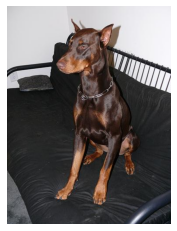

Foto selecionada aleatoriamente em:../input/dog-breed-recognition-v3/dogs/train/n02107142-Doberman/n02107142_17564.jpg
Probabilidade de 99.24% de ser um n02107142-Doberman


In [12]:
# Seleciona uma foto aleatoria e verifica saida do modelo

train_dir = '../input/dog-breed-recognition-v3/dogs/train/*/*'
enroll_data = np.array(glob(train_dir))
img_path = np.random.choice(enroll_data, 1)[0]
recgn_utils.imshow(img_path)
print(f'Foto selecionada aleatoriamente em:{img_path}')
pred_breed, pred_prob = recgn_utils.predict_breed_dog(model, class_names, img_mean, img_std, img_path, gpu_on)
print(f'Probabilidade de {pred_prob*100:.2f}% de ser um {pred_breed}')